In [12]:
import csv
import os
import tensorflow as tf
import keras
from keras import layers, models
import sklearn.model_selection
import numpy as np
import math

# tf.config.set_visible_devices([], 'GPU')


In [13]:

user_data = csv.DictReader(open('u.csv', encoding='utf8'))

activity_destination_pairs = []
for row in user_data:
    activities = eval(row['Preferred Activities'])
    activities = list(map(lambda activity: activity.strip(), activities))

    destinations = eval(row['Bucket list destinations Sri Lanka'])
    destinations = list(map(lambda destination: destination.strip(), destinations))

    activity_destination_pairs.append((activities, destinations))

unique_activities = list(set([activity for activities, _ in activity_destination_pairs for activity in activities]))
unique_activities.sort()

unique_destinations = list(set([destination for _, destinations in activity_destination_pairs for destination in destinations]))
unique_destinations.sort()

print(len(activity_destination_pairs), len(unique_activities), len(unique_destinations))


10000 68 157


In [14]:
review_scores_data = csv.DictReader(open('review_scores.csv', encoding='utf8'))

review_scores = {}
for row in review_scores_data:
    place_name = row['name'].strip()
    scores = eval(row['scores'])
    review_scores[place_name] = sum(scores)/len(scores)

place_data = csv.DictReader(open('p.csv', encoding='utf8'))

place_ratings = {}
for row in place_data:
    place_name = row['name'].strip()
    if not (row['rating'] and row['user_ratings_total']):
        continue

    rating = float(row['rating'])
    total_ratings = int(row['user_ratings_total'])
    total_ratings = math.log10(total_ratings)
    review_score = review_scores.get(place_name, 1)

    place_ratings[place_name] = [rating, total_ratings, review_score]

place_score_array = np.array([place_ratings[place] if place in place_ratings else [5, 0, 1] for place in unique_destinations])
place_score_array = sklearn.preprocessing.minmax_scale(place_score_array, axis=0)
# print(place_score_array)


In [15]:

def get_rating(place_index):
    rating, total_ratings, review_score = place_score_array[place_index]
    if total_ratings == 0:
        total_ratings = 1
    return rating*total_ratings*review_score


data_X = []
data_Y = []

activity_destination_weights = np.zeros(shape=(len(unique_activities), len(unique_destinations)))

for activities, destinations in activity_destination_pairs:
    for activity in activities:
        for destination in destinations:
            activity_destination_weights[unique_activities.index(activity)][unique_destinations.index(destination)] += 1

activity_destination_weights = sklearn.preprocessing.minmax_scale(activity_destination_weights, axis=1)
# print(activity_destination_weights)

for activities, destinations in activity_destination_pairs:
    X = [1 if activity in activities else 0 for activity in unique_activities]
    Ys = []
    for activity in activities:
        i = unique_activities.index(activity)
        Ys.append(activity_destination_weights[i])
    Y = np.sum(Ys, axis=0)
    data_X.append(X)
    data_Y.append(Y)


data_X = np.array(data_X)
data_Y = np.array(data_Y)


train_X, test_X, train_Y, test_Y = sklearn.model_selection.train_test_split(data_X, data_Y, test_size=0.20)
train_X, val_X, train_Y, val_Y = sklearn.model_selection.train_test_split(train_X, train_Y, test_size=0.20)


print(len(train_X), len(val_X), len(test_X))


6400 1600 2000


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 628)               43332     
                                                                 
 dense_9 (Dense)             (None, 157)               98753     
                                                                 
Total params: 142,085
Trainable params: 142,085
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
200/200 [==============================] - 1s 3ms/step - loss: 0.0899 - accuracy: 0.1567 - val_loss: 0.0507 - val_accuracy: 0.1731
Epoch 2/40
200/200 [==============================] - 0s 2ms/step - loss: 0.0492 - accuracy: 0.2066 - val_loss: 0.0470 - val_accuracy: 0.2081
Epoch 3/40
200/200 [==============================] - 0s 2ms/step - loss: 0.0455 - accuracy: 0.2558 - val_loss: 0.0434 - val_accuracy: 0.2456
Epoch 4/40
200/200

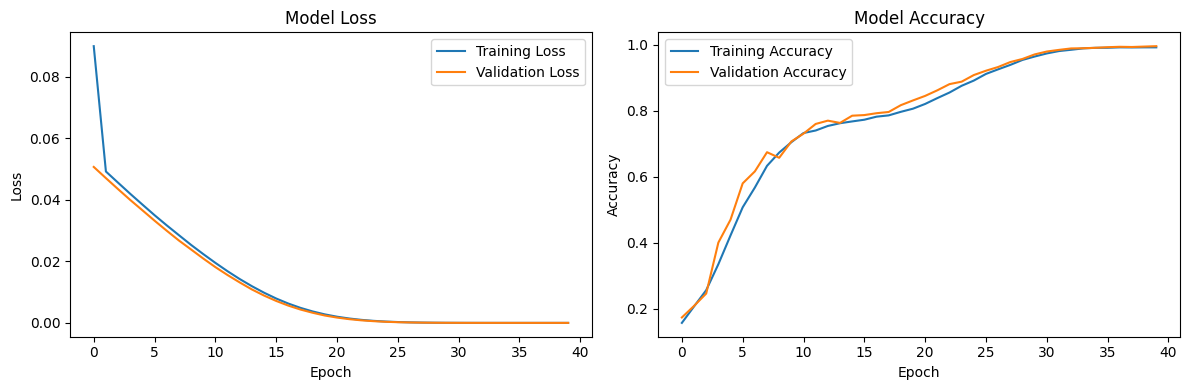

In [20]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

model = keras.Sequential([
    layers.Input(shape=(len(unique_activities),)),
    layers.Dense(units=len(unique_destinations)*4, activation='sigmoid'),
    layers.Dense(units=len(unique_destinations)),
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy'])
model.summary()

history = model.fit(train_X, train_Y, validation_data=(val_X, val_Y), epochs=40)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:

results = model.evaluate(test_X, test_Y)
print("test loss, test acc:", results)


63/63 [==============================] - 0s 1ms/step - loss: 2.0077e-06 - accuracy: 0.9900
test loss, test acc: [2.0076533928659046e-06, 0.9900000095367432]


In [25]:
def predict_top_5_destinations(activities):
    activity_vector = [1 if activity in activities else 0 for activity in unique_activities]
    output = model.call(inputs=tf.convert_to_tensor([activity_vector]))
    top_predictions = tf.math.top_k(output, k=5)

    prediction_scores = top_predictions.values.numpy().tolist()[0]
    top_indices = top_predictions.indices.numpy().tolist()[0]

    prediction_scores = list(filter(lambda x: x > .5, prediction_scores))
    predictions = [unique_destinations[idx] for idx in top_indices[:len(prediction_scores)]]

    return predictions, prediction_scores


def refined_top_5_destinations(input_data):
    initial_predictions, initial_scores = predict_top_5_destinations(input_data)

    for single_activity in input_data:
        refined_predictions, refined_scores = predict_top_5_destinations([single_activity])
        if len(refined_predictions) == 0:
            continue
        top_prediction, top_score = refined_predictions[0], refined_scores[0]

        if top_prediction not in initial_predictions:
            initial_predictions.insert(0, top_prediction)
            initial_scores.insert(0, top_score)

    return initial_predictions[:5], initial_scores[:5]


def predict_and_print(activities):
    if len(activities) == 1:
        predictions, prediction_scores = predict_top_5_destinations(activities)
    else:
        predictions, prediction_scores = refined_top_5_destinations(activities)

    print(', '.join(activities), dict(zip(predictions, map(lambda score: round(score, 2), prediction_scores))))


predict_and_print(['hot springs'])
predict_and_print(['elephant rides'])
predict_and_print(['museum visits'])
predict_and_print(['waterfalls'])
predict_and_print(['hot springs', 'elephant rides'])
predict_and_print(['museum visits', 'waterfalls'])
predict_and_print(['hot springs', 'elephant rides', 'waterfalls'])
predict_and_print(['cycling', 'historical monuments', 'village homestays'])


hot springs {'Madunagala Hot Water Spring': 1.1, 'Kanniya Hot Springs': 1.08, 'Maha Oya Hot Water Springs': 1.07, 'Mahapelessa Hot Springs': 1.05, 'Sigiriya': 0.65}
elephant rides {'Udawalawe': 1.11, 'Pinnawala': 1.1, 'Sigiriya': 0.69, 'Mirissa Beach': 0.62, 'Trincomalee': 0.62}
museum visits {'Kandy National Museum': 1.08, 'National Museum Galle': 1.06, 'Ratnapura Gem Museum': 1.05, 'Folk Museum': 0.98, 'Colombo National Museum': 0.95}
waterfalls {"St Clair's Falls": 1.1, 'Ravan Ella Waterfall': 1.05, 'Diyaluma Falls': 1.02, 'Bambarakiri Ella': 1.01, 'Bambarakanda Falls': 0.97}
hot springs, elephant rides {'Udawalawe': 1.09, 'Madunagala Hot Water Spring': 1.08, 'Pinnawala': 1.06, 'Maha Oya Hot Water Springs': 1.06, 'Kanniya Hot Springs': 1.06}
museum visits, waterfalls {'Kandy National Museum': 1.07, "St Clair's Falls": 1.06, 'National Museum Galle': 1.02, 'Ratnapura Gem Museum': 1.02, 'Ravan Ella Waterfall': 1.01}
hot springs, elephant rides, waterfalls {"St Clair's Falls": 1.1, 'Mad

In [27]:
model.save('TechCrew_FinalModel.h5')